In [1]:
#commented unecessary print statements
#defined functions in order to use numba pre compiler
#coverted some unecessary matrices to scalras inorder to conserve memory (eg. random numbers)

#contains the Watts-Strogatz initial network as a separate function

#random nodes are infected initially. This may not highlight the properties of the network. 
#That is, it might not differentiate between small world networks and large world networks. 


In [2]:
#importing the required libraries

import networkx as nx #network library to generate inital networks and perform various network operations
import matplotlib.pyplot as plt #for plotting
import numpy as np #for using arrays and vectorising the code wherever possible
import scipy
import random
import cProfile #for timing the loops
from numba import jit #numba precomplier to make the code faster
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [3]:
#opening a file to store data
f = open("critic_time_series_ws_bettselec.txt","w+") 

In [4]:
#making the nodes interact and hence transfering doses

# @jit(nopython=True)
def interaction(N,k,adj_mat,indi_state,d,p) :
    for n in range(0,N): #loop for nodes
#         print('n = ',n)
        connec_neigh_list = list(G.neighbors(n))
        partner[n,k] = random.choice(connec_neigh_list)
#         print("partner=",partner[n,k])
        z1 = np.random.uniform()

        #if one is infected and the other is susceptible and they are connected
        if (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
#         if (indi_state[n,k-1] == 1) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 print('postive dose to the one')
                d[n,k] = 1 #the one receives constant dose
            else :
#                 'interaction but no dose'
                d[n,k] = 0
        #if both are infected and they are connected
        elif (adj_mat[n,partner[n,k]] == 1) and (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
#         elif (indi_state[n,k-1] == 2) and (indi_state[partner[n,k],k-1] == 2) :
            if p >= z1 :
#                 'postive dose for both'
                d[n,k] = 1 #the other receives constant dose
            else :
#                 'interaction but no dose'
                d[n,k] = 0
        else :
#             'no interaction at all'
                d[n,k] = 0
        
    return d

In [5]:
#updating the cumulative dose distribution

def upd_cumu(k,mem_time_steps,d,d_ini) :
    #     updating cumulative dose
    D[:,k] = 0
    m = k - (mem_time_steps)
    if m > 0 :
        D[:,k] = np.sum(d[:,m:k+1:1],1)
    if m <= 0 :
        while m <= 0 :
            m = m + 1
        D[:,k] = np.sum(d[:,m:k+1:1],1) + np.sum(d_ini[:,0:((mem_time_steps-(k-m))):1],1)
    
    return D

In [6]:
def upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) :
    for n in range(0,N):
#         print(n)
#         print(k)
#         if threshold is met and is susceptible
        if (D[n,k] >= d_star) and (indi_state[n,k-1] == 1) :
#             'above thresh becomes infected'
            indi_state[n,k] = 2 #susceptible becomes infected
        elif (D[n,k] < d_star) and (indi_state[n,k-1] == 2) :
#         recovery : if drops bel threshold and is infected
            z2 = np.random.uniform()
            if r >= z2 :
#                 'below thresh'
                z3 = np.random.uniform()
                if rho >= z3 :
#                     'below thresh becomes susceptible'
                    indi_state[n,k] = 1
                else :
#                     'below thresh becomes immune'
                    indi_state[n,k] = 3
            else :
#                 'below thresh stays infected'
                indi_state[n,k] = 2
        else :
#             'retains previous state'
            indi_state[n,k] = indi_state[n,k-1]

    phi[0,k] = np.count_nonzero(indi_state[:,k] == 2)/N
#     kount = kount + 1

    return phi, indi_state

In [7]:
#creating the static Watts-Strogatz network
def static_network(N,nn,p_rew) :
    G = nx.watts_strogatz_graph(N,nn,p_rew) #no rewiring for now
#     print("G_type = ",type(G))

    # #relabelling the nodes to start with 1
    # G = nx.convert_node_labels_to_integers(G,first_label=1,ordering='default',label_attribute=None)

    #getting the nodes as a list
    node_list = [G.nodes]

    #and converting it into an array(column vector)
    node_array = np.asarray(node_list).reshape(N,1)


    #obtaining the edges via the adjancency matrix
    adj_mat = nx.adjacency_matrix(G,nodelist=range(N))
    adj_mat = scipy.sparse.csr_matrix.toarray(adj_mat)
    
#     connec_neigh_list = list(G.neighbors(n))
    
    return G, adj_mat
#     print("adj_mat_type = ",type(adj_mat))
#     print("adj_mat_shape = ",adj_mat.shape)
#     print(adj_mat)

#     nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')
    

In [8]:
#initial conditions of doses
#implementing marc's initial condition

def initial_dose_cond(indi_state,d_ini,mem_time_steps,X,start,N) : 
    
#     infec = np.arange(0,np.int32(start*N),1) #selectively infecting few individuals as initial condition
#     # np.random.shuffle(infec)
#     infec = np.asarray(infec).reshape(np.int32(start*N),1)
#     if start != 0 :
#         indi_state[infec[:,0],0] = 2
    
    infec_count = 0
    for e in G.edges() :
        if infec_count < np.int32(start*N) :
            if indi_state[e[0],0] != 2 :
                indi_state[e[0],0] = 2
                infec_count = infec_count + 1
        if infec_count < np.int32(start*N) :
            if  indi_state[e[1],0] != 2 :
                indi_state[e[1],0] = 2
                infec_count = infec_count + 1
        if infec_count >= np.int32(start*N) :
            break
    
    I = np.where(indi_state[:,0]==2)
    I = np.transpose(np.asarray(I))

    if len(I) != 0 :
        for i in range(0,len(I)) : 
            dose_slots = np.random.choice(mem_time_steps,size=X,replace=False)
            for j in range(0,len(dose_slots)) :
                d_ini[I[i],dose_slots[j]] = 1
    else :
        d_ini[:,0:] = 0

#     print('d_ini=',d_ini)

    return d_ini

In [9]:
#user controlled variables

for p in range(6,11) : #time loop
    p = p*0.1
#     p = 1
    for start in range(0,11) : #initial condition loop
        start = start*0.1
#         start = 1
        for p_rew in range(0,11) : #probability of rewiring loop
            p_rew = p_rew*0.1
#             p_rew = 1
            print("p=",p)
            print("start=",start)
            print("p_rew=",p_rew)
            
            nn = 6 #each node is connected to nn number of nearest neighbours, nn-1 neighbors if nn is odd

            rho = 1   #probability of becoming susceptible after recovery
            r = 1    #probability of recovery when dose level drops below threshold

            N = 1000   #number of individuals
            T = 1000  #number of time steps

            mem_time_steps = 12 #the number of previous time steps which the individual remembers about 

#             d_star = 3*np.ones((N,1),dtype=np.int32)
            d_star = 3.

            phi = 999*np.ones([1,T]) #fraction of steady state infected

            t = np.arange(0,T) #time steps
            t = np.asarray(t).reshape(1,T)

            partner = 999*np.ones((N,T),dtype=np.int32) #partners used to form pairs in every time step
            partner = np.asarray(partner)

            indi_state = np.zeros((N,T),dtype=np.int32) #stores the state of eahc individual
            indi_state[:,0] = 1


            d_ini = np.zeros((N,mem_time_steps))
            d = 999*np.ones((N,T)) #doses
            D = 999*np.ones((N,T)) #cumulative doses
            
            #creating the static network
            G, adj_mat = static_network(N,nn,p_rew) #calling the function to create the static network
#             print(adj_mat)
#             nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=True,nodecolor='r',edge_color='b')

            #initial state of individuals
            #MEHTODOLOGICALY grouping into i, s or r
            #this is to make a local fraction of the population infected initially
            #previously, random parts/nodes of the population were infected intially 
            
            X = 4
            d_ini = initial_dose_cond(indi_state,d_ini,mem_time_steps,X,start,N)

            phi[0,0] = np.count_nonzero(indi_state[:,0] == 2)/N
            f.write("%f\t" % (phi[0,0]))
            f.flush()

            for k in range(1,T): #loop for time
#                 print('k = ',k)
                interaction(N,k,adj_mat,indi_state,d,p) #calling the interaction function
                upd_cumu(k,mem_time_steps,d,d_ini) #calling the fucntions to obtain and update cumulative dose
                upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r) #calling the function to update the state of the nodes
#             print(phi)
#             phi_star = sum(phi[0,k-5:k])/5 #obtaining average phi_star of the last 100 time steps
#             print("phi_star=",phi_star)

                f.write("%f\t" % (phi[0,k]))
                f.flush()
            f.write("\n")
            f.flush()

p= 0.6000000000000001
start= 0.0
p_rew= 0.0
p= 0.6000000000000001
start= 0.0
p_rew= 0.1
p= 0.6000000000000001
start= 0.0
p_rew= 0.2
p= 0.6000000000000001
start= 0.0
p_rew= 0.30000000000000004
p= 0.6000000000000001
start= 0.0
p_rew= 0.4
p= 0.6000000000000001
start= 0.0
p_rew= 0.5
p= 0.6000000000000001
start= 0.0
p_rew= 0.6000000000000001
p= 0.6000000000000001
start= 0.0
p_rew= 0.7000000000000001
p= 0.6000000000000001
start= 0.0
p_rew= 0.8
p= 0.6000000000000001
start= 0.0
p_rew= 0.9
p= 0.6000000000000001
start= 0.0
p_rew= 1.0
p= 0.6000000000000001
start= 0.1
p_rew= 0.0
p= 0.6000000000000001
start= 0.1
p_rew= 0.1
p= 0.6000000000000001
start= 0.1
p_rew= 0.2
p= 0.6000000000000001
start= 0.1
p_rew= 0.30000000000000004
p= 0.6000000000000001
start= 0.1
p_rew= 0.4
p= 0.6000000000000001
start= 0.1
p_rew= 0.5
p= 0.6000000000000001
start= 0.1
p_rew= 0.6000000000000001
p= 0.6000000000000001
start= 0.1
p_rew= 0.7000000000000001
p= 0.6000000000000001
start= 0.1
p_rew= 0.8
p= 0.6000000000000001
start=

p= 0.7000000000000001
start= 0.30000000000000004
p_rew= 0.5
p= 0.7000000000000001
start= 0.30000000000000004
p_rew= 0.6000000000000001
p= 0.7000000000000001
start= 0.30000000000000004
p_rew= 0.7000000000000001
p= 0.7000000000000001
start= 0.30000000000000004
p_rew= 0.8
p= 0.7000000000000001
start= 0.30000000000000004
p_rew= 0.9
p= 0.7000000000000001
start= 0.30000000000000004
p_rew= 1.0
p= 0.7000000000000001
start= 0.4
p_rew= 0.0
p= 0.7000000000000001
start= 0.4
p_rew= 0.1
p= 0.7000000000000001
start= 0.4
p_rew= 0.2
p= 0.7000000000000001
start= 0.4
p_rew= 0.30000000000000004
p= 0.7000000000000001
start= 0.4
p_rew= 0.4
p= 0.7000000000000001
start= 0.4
p_rew= 0.5
p= 0.7000000000000001
start= 0.4
p_rew= 0.6000000000000001
p= 0.7000000000000001
start= 0.4
p_rew= 0.7000000000000001
p= 0.7000000000000001
start= 0.4
p_rew= 0.8
p= 0.7000000000000001
start= 0.4
p_rew= 0.9
p= 0.7000000000000001
start= 0.4
p_rew= 1.0
p= 0.7000000000000001
start= 0.5
p_rew= 0.0
p= 0.7000000000000001
start= 0.5
p_r

p= 0.8
start= 0.9
p_rew= 0.0
p= 0.8
start= 0.9
p_rew= 0.1
p= 0.8
start= 0.9
p_rew= 0.2
p= 0.8
start= 0.9
p_rew= 0.30000000000000004
p= 0.8
start= 0.9
p_rew= 0.4
p= 0.8
start= 0.9
p_rew= 0.5
p= 0.8
start= 0.9
p_rew= 0.6000000000000001
p= 0.8
start= 0.9
p_rew= 0.7000000000000001
p= 0.8
start= 0.9
p_rew= 0.8
p= 0.8
start= 0.9
p_rew= 0.9
p= 0.8
start= 0.9
p_rew= 1.0
p= 0.8
start= 1.0
p_rew= 0.0
p= 0.8
start= 1.0
p_rew= 0.1
p= 0.8
start= 1.0
p_rew= 0.2
p= 0.8
start= 1.0
p_rew= 0.30000000000000004
p= 0.8
start= 1.0
p_rew= 0.4
p= 0.8
start= 1.0
p_rew= 0.5
p= 0.8
start= 1.0
p_rew= 0.6000000000000001
p= 0.8
start= 1.0
p_rew= 0.7000000000000001
p= 0.8
start= 1.0
p_rew= 0.8
p= 0.8
start= 1.0
p_rew= 0.9
p= 0.8
start= 1.0
p_rew= 1.0
p= 0.9
start= 0.0
p_rew= 0.0
p= 0.9
start= 0.0
p_rew= 0.1
p= 0.9
start= 0.0
p_rew= 0.2
p= 0.9
start= 0.0
p_rew= 0.30000000000000004
p= 0.9
start= 0.0
p_rew= 0.4
p= 0.9
start= 0.0
p_rew= 0.5
p= 0.9
start= 0.0
p_rew= 0.6000000000000001
p= 0.9
start= 0.0
p_rew= 0.700000000

p= 1.0
start= 0.7000000000000001
p_rew= 0.2
p= 1.0
start= 0.7000000000000001
p_rew= 0.30000000000000004
p= 1.0
start= 0.7000000000000001
p_rew= 0.4
p= 1.0
start= 0.7000000000000001
p_rew= 0.5
p= 1.0
start= 0.7000000000000001
p_rew= 0.6000000000000001
p= 1.0
start= 0.7000000000000001
p_rew= 0.7000000000000001
p= 1.0
start= 0.7000000000000001
p_rew= 0.8
p= 1.0
start= 0.7000000000000001
p_rew= 0.9
p= 1.0
start= 0.7000000000000001
p_rew= 1.0
p= 1.0
start= 0.8
p_rew= 0.0
p= 1.0
start= 0.8
p_rew= 0.1
p= 1.0
start= 0.8
p_rew= 0.2
p= 1.0
start= 0.8
p_rew= 0.30000000000000004
p= 1.0
start= 0.8
p_rew= 0.4
p= 1.0
start= 0.8
p_rew= 0.5
p= 1.0
start= 0.8
p_rew= 0.6000000000000001
p= 1.0
start= 0.8
p_rew= 0.7000000000000001
p= 1.0
start= 0.8
p_rew= 0.8
p= 1.0
start= 0.8
p_rew= 0.9
p= 1.0
start= 0.8
p_rew= 1.0
p= 1.0
start= 0.9
p_rew= 0.0
p= 1.0
start= 0.9
p_rew= 0.1
p= 1.0
start= 0.9
p_rew= 0.2
p= 1.0
start= 0.9
p_rew= 0.30000000000000004
p= 1.0
start= 0.9
p_rew= 0.4
p= 1.0
start= 0.9
p_rew= 0.5
p= 

In [10]:
# #creating the static network
# G, adj_mat = static_network(25,6,1) #calling the function to create the static network
# nx.draw_networkx(G,pos=nx.circular_layout(G),with_labels=False,nodecolor='r',edge_color='b')

In [11]:
# %timeit interaction(N,k,adj_mat,indi_state,d,p)
# %timeit upd_cumu(k,mem_time_steps,d,d_ini)
# %timeit upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r)
# %timeit upd_indi_state(k,N,D,d_star,indi_state,phi,rho,r)

In [12]:
'''interactive plot'''

# a = np.loadtxt("local_epid_p_phiini_prewphi_star_data.txt")[:,0]
# b =  np.loadtxt("local_epid_p_phiini_prewphi_star_data.txt")[:,1]
# c =  np.loadtxt("local_epid_p_phiini_prewphi_star_data.txt")[:,2]
# d = np.loadtxt("local_epid_p_phiini_prewphi_star_data.txt")[:,3]

# # Import dependencies
# import plotly
# import plotly.graph_objs as go

# # Configure Plotly to be rendered inline in the notebook.
# plotly.offline.init_notebook_mode()

# # Configure the trace.
# trace = go.Scatter3d(
#     x= a.transpose(),  # <-- Put your data instead
#     y= b.transpose(),  # <-- Put your data instead
#     z= c.transpose(),  # <-- Put your data instead
#     mode='markers',
#     marker=dict(
#         size=12,
#         color=d,                # set color to an array/list of desired values
#         colorscale='Viridis',   # choose a colorscale
#         colorbar = dict(title = ''),
#         opacity=0.8
#     )
# )

# # Configure the layout.
# layout = go.Layout(
#                     scene = dict(
#                     xaxis = dict(
#                         title='p'),
#                     yaxis = dict(
#                         title=r'$phi_{ini}$'),
#                     zaxis = dict(
#                         title= r'$p_{rew}$'),),
#                     width=700,
#                     margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
#                     )

# data = [trace]

# plot_figure = go.Figure(data=data, layout=layout)

# # Render the plot.
# plotly.offline.iplot(plot_figure)

'interactive plot'

In [13]:
'''colour plot''' 

# # a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# # b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# # c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
# d = np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[:,3]


# counter = 0
# l = 0
# fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
# i = 0
# for row in ax:
#     k = 0
#     for col in row:
#         print(col)
#         ax[i, k].set_title('p= %f' %l)
#         l = l + 0.1
#         j = 121*counter
#         im = col.scatter(np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("critic_p_phiini_prewphi_star_data.txt")[j:121*(counter+1),3],s=200,vmin=0, vmax=1)
#         k = k + 1
#         counter = counter + 1
#     i = i + 1

# nax = fig.add_subplot(111, frame_on = False)
# nax.set_xticks([])
# nax.set_yticks([])
# fig.suptitle(r'$\phi^*$, epidemic threshold model. $nn=6,N=1000,N_t=1000,T=2,d^*=1,d=1,r=0.5$',fontsize = 20)
# nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
# nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
# fig.subplots_adjust(right=0.8)

# cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
# fig.colorbar(im, cax=cbar_ax)

# plt.savefig("test.svg", format="svg")

# # for i in range(1, 13):
# #     plt.subplot(4, 3, i)
# #     j = 121*counter
# #     print(j)
# #     plt.scatter(np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),3],s=200)
# # #     plt.colorbar()
# #     # plt.title(r'$\phi^*$, Critical Threshold Model. $d^*=3,T=12, N=100,N_t=1000,r=1,rho=1$',fontsize=15,fontweight='bold')
# #     # plt.title(r'$\phi^*$, Epidemic Threshold Model. $d^*=1,T=2, N=100,N_t=1000,r=0.5,rho=1$',fontsize=15,fontweight='bold')
# #     plt.title('p')
# #     plt.xlabel(r'$\phi_{ini}$',fontsize=15)
# #     plt.ylabel(r'$\phi_{rew}$',fontsize=15)
# #     counter = counter + 1 


'colour plot'

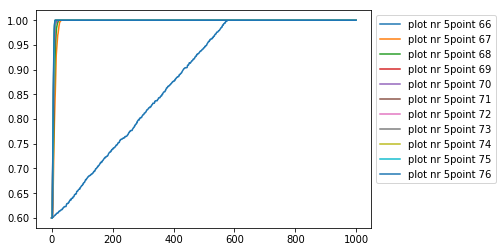

In [14]:
for i in range(484+66,484+77,1) :
    nr=(i)%121
    a = np.loadtxt("critic_time_series_ws_bettselec.txt")[i,:]
    plt.plot(a,label='plot nr %i'%(int(i/121)+1)+"point %i"%nr)
    plt.legend(bbox_to_anchor=(1,1))
#     plt.axhline(y=0.6)
#     plt.axhline(y=0.4)

#     k = 1000
#     phi_star = sum(a[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
#     print("phi_star=",phi_star)

In [15]:
# '''time series plot'''

# for i in range(1087,1088) :
#     nr=(i+1)%121
#     a = np.loadtxt("critic_time_series.txt")[i,:]
#     plt.plot(a,label='plot nr %i'%int(i/121)+"point %i"%nr)
#     plt.legend(bbox_to_anchor=(1,1))
#     plt.xlim([0,15])
# #     plt.axhline(y=0.6)
# #     plt.axhline(y=0.4)

# #     k = 1000
# #     phi_star = sum(a[0,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
# #     print("phi_star=",phi_star)

In [18]:
'''averaging time series data'''
f = open("critic_phi_star_data_ws_betterselec.txt","w+") 
k = 1000
# phi_star = sum(a[counter,k-100:k])/100 #obtaining average phi_star of the last 100 time steps
# print("phi_star=",phi_star)

counter = 0
for p in range(0,11):
    p = p*0.1
    print(p)
    for start in range(0,11):
        start = start*0.1
        for p_rew in range(0,11) :
            p_rew = p_rew*0.1
            a = np.loadtxt("critic_time_series_ws_bettselec.txt")[counter,:]
            phi_star = np.average(a[k-100:k])
            f.write("%f\t%f\t%f\t%f\n" % (p,start,p_rew,phi_star))
            f.flush()
            counter = counter + 1
print(counter)

0.0


KeyboardInterrupt: 

In [ ]:
'''colour plot again :P'''
# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("critic_phi_star_data_ws_betterselec.txt")[:,3]


counter = 0
l = 0
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
        print(col)
        ax[i, k].set_title('p= %f' %l)
        l = l + 0.1
        j = 121*counter
        im = col.scatter(np.loadtxt("critic_phi_star_data_ws_betterselec.txt")[j:121*(counter+1),1],np.loadtxt("critic_phi_star_data_ws_betterselec.txt")[j:121*(counter+1),2], c=np.loadtxt("critic_phi_star_data_ws_betterselec.txt")[j:121*(counter+1),3],s=200,vmin=0, vmax=1)
        k = k + 1
        counter = counter + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$\phi^*$, critical mass model. $nn=6,N=1000,N_t=1000,T=12,d^*=3,d=1,r=1$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("critic_params_bettersel.svg", format="svg")

# for i in range(1, 13):
#     plt.subplot(4, 3, i)
#     j = 121*counter
#     print(j)
#     plt.scatter(np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),1],np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),2], c=np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[j:121*(counter+1),3],s=200)
# #     plt.colorbar()
#     # plt.title(r'$\phi^*$, Critical Threshold Model. $d^*=3,T=12, N=100,N_t=1000,r=1,rho=1$',fontsize=15,fontweight='bold')
#     # plt.title(r'$\phi^*$, Epidemic Threshold Model. $d^*=1,T=2, N=100,N_t=1000,r=0.5,rho=1$',fontsize=15,fontweight='bold')
#     plt.title('p')
#     plt.xlabel(r'$\phi_{ini}$',fontsize=15)
#     plt.ylabel(r'$\phi_{rew}$',fontsize=15)
#     counter = counter + 1 

In [ ]:
a = np.loadtxt("critic_time_series_ws_bettselec.txt")[0,:]

df = pd.DataFrame(a,index=range(0,1000))
# a = np.loadtxt("critic_time_series_ws_winnie.txt")[120,:]
# df[2] = pd.DataFrame(a,index=range(0,1000))

for i in range(1,1321) :
    print(i)
    a = np.loadtxt("critic_time_series_ws_bettselec.txt")[i,:]
    df[i] = pd.DataFrame(a,index=range(0,1000))
df


In [ ]:
df.to_csv('df_critic_time_series_ws_bettselec.csv')

In [ ]:
df = pd.read_csv('df_critic_time_series_ws_bettselec.csv')
df.iloc[:, [847+22+1]]

In [ ]:
point = 847+22+1

x = df.iloc[:, [point]]
# smooth = x.rolling(window=100,center=False).mean().shift(-199)
smooth = x.rolling(window=100,center=True).mean()
# plt.plot(smooth)
a = np.loadtxt("critic_time_series_ws_bettselec.txt")[point-1,:]
plt.plot(a)
plt.show()
print(smooth.iloc[[point], [0]])
# print(np.isnan(smooth.iloc[[0], [0]]))
print(pd.isnull(smooth.iloc[[0], [0]]))

In [ ]:
def time_reach_ss(point,lim,tol,window_size) :
    x = df.iloc[:, [point]]
    # smooth = x.rolling(window=100,center=False).mean().shift(-199)
    smooth = x.rolling(window=window_size,center=True).mean()
    count = 0
    b = np.loadtxt("critic_phi_star_data_ws_betterselec.txt")[point-1,3]
    print('steady_state_phi_star=',b)
    for i in range(0,1000) :
        if not(pd.isnull(smooth.iloc[[i], [0]]).bool()): 
#             print((smooth.iloc[[i], [0]]))
            j = i
            while (((smooth.iloc[[j], [0]]) < (tol+b)) & ((smooth.iloc[[j], [0]]) > (b-tol)) & (j<i+100)).bool() :
                count = count + 1
#                 print('count = ',count)
                j = j + 1
    #             if j == i + 100 : 
            if count >= lim :
                count = 0
                print('steady state reached at i = ',i)
                return i

In [ ]:
#opening a file to store data
g = open("critic_ss_ws_betterselec.txt","w+") 

point = 1
for p in range(0,11) :
    p = p*0.1
    for start in range(0,11) :
        start = start*0.1
        for p_rew in range(0,11) :
            p_rew = p_rew*0.1
            print('p=',p)
            print('start=',start)
            print('p_rew=',p_rew)
#             for point in range(484+77,484+77+11) :
            print('point=',point)
            tol = 0.005
            lim = 200
            window_size = 50
            i = time_reach_ss(point,lim,tol,window_size)
            if i is not None :
                g.write("%f\t%f\t%f\t%f\n" % (p,start,p_rew,i))
                g.flush()
                point = point + 1
            else :
#                 g.write("%f\t%f\t%f\t\n" % (p,start,p_rew))
                point = point + 1

In [ ]:
'''colour plot again :P'''
# a = np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,0]
# b =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,1]
# c =  np.loadtxt("epid_p_phiini_prew_phi_star_data.txt")[:,2]
d = np.loadtxt("critic_ss_ws_betterselec.txt")[:,3]
print(np.loadtxt("critic_ss_ws_betterselec.txt")[1238,0])
print(len(d))
count = 0
plot_count = 1
j = 0
l = 0
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,14))
i = 0
for row in ax:
    k = 0
    for col in row:
        print(col)
        ax[i, k].set_title('p= %f' %l)
#         count = count + plot_count-1
        plot_count = 0
        print(count,round(l,2))
        print(np.loadtxt("critic_ss_ws_betterselec.txt")[count,0])
        while (count < len(d)-1) and np.loadtxt("critic_ss_ws_betterselec.txt")[count,0] == round(l,2)  :
            plot_count = plot_count + 1
            count = count + 1
#             print(count)
        end =  count
#         count = plot_count-1
        im = col.scatter(np.loadtxt("critic_ss_ws_betterselec.txt")[j:end,1],np.loadtxt("critic_ss_ws_betterselec.txt")[j:end,2], c=np.loadtxt("critic_ss_ws_betterselec.txt")[j:end,3],s=200,vmin=26,vmax=100)
        j = end
        l = l + 0.1
        k = k + 1
    i = i + 1

nax = fig.add_subplot(111, frame_on = False)
nax.set_xticks([])
nax.set_yticks([])
fig.suptitle(r'$t^*$, critical mass model. $nn=6,N=1000,N_t=1000,T=12,d^*=3,d=1,r=1$',fontsize = 20)
nax.set_xlabel(r'$\phi_{ini}$', fontsize = 20, labelpad=20)
nax.set_ylabel(r'$p_{rew}$', fontsize = 20, labelpad=40)
fig.subplots_adjust(right=0.8)

cbar_ax = fig.add_axes([0.85, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.savefig("critic_steady_state_betterselec.svg", format="svg")